# CV_HW_1
## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [39]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

## Загружаем исходные данные

In [5]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [6]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [7]:
train_img.shape

(42000, 28, 28)

In [93]:
test_img.shape

(28000, 28, 28)

## Визуализируем исходные данные

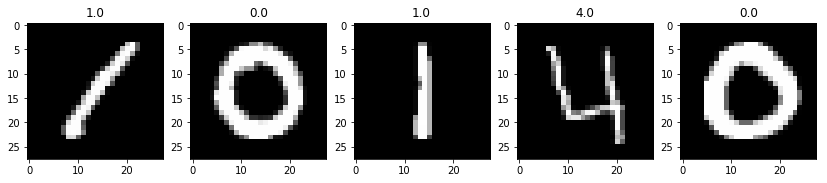

In [94]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

### Строим модель на всех признаках

In [132]:
# преобразуем признаки в необходимый вид
X = train_img.reshape(-1, 28 * 28).astype(np.float32)

In [133]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X, train_label, test_size=0.2,
    random_state=42)

In [115]:
X.shape

(42000, 784)

In [116]:
%%time
clf = LogisticRegression()
model_all_features = clf.fit(X_train, y_train)

Wall time: 16.6 s


In [117]:
y_pred = model_all_features.predict(X_test)

In [118]:
print(f'Accuracy with all features: {accuracy_score(y_test, y_pred):.2f}')

Accuracy with all features: 0.91


т.о. получили обучение модели за 16 с  с точностью 0,91

## Сделаем отбор признаков с момощью PCA

In [134]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [135]:
U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

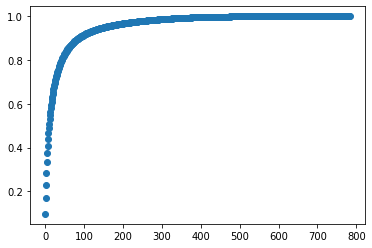

In [136]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [137]:
S_thr = 0.90  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=86 S=0.901


In [138]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    Xrot_reduced, train_label, test_size=0.2,
    random_state=42)

In [140]:
%%time
clf = LogisticRegression()
model_90 = clf.fit(X_train, y_train)

Wall time: 6.16 s


In [141]:
y_pred = model_90.predict(X_test)

In [142]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.91


при сокращении признаков, до 90% описания, удалось уменьшить время обучения модели в 2,5 раза, и сохранить качество 0,91

## Предобрабатываем тестовые данные под параметры модели (необходимо конверитровать данные в необходимое число признаков)

In [85]:
test = test_img.reshape(-1, 28 * 28).astype(np.float32)`

In [ ]:
# центрируем данные
test_mean = test.mean(axis=0)
test -= test_mean

In [95]:
# матрица ковариации признаков
cov = np.dot(test.T, test) / test.shape[0]

U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)

In [96]:
S_thr = 0.90  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

In [97]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(test, U[:, :n_comp])

In [98]:
y_pred_test = model_90.predict(Xrot_reduced)

In [99]:
y_pred_test.shape

(28000,)

## Готовим файл для отправки

In [148]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p.astype('int')))

submission scored 0.90939